In [155]:
import numpy as np
from numba import jit
import os,sys,re
from cellpose import io
example_data='example_data/height/'
import matplotlib.pyplot as plt

Get file names from directory

In [156]:
files=os.listdir(example_data)

In [157]:
images = []
data = []
for file in files:
    if file.endswith(".png"):
        images.append(file)
        data.append(file[:-4])

## Retrieve scale from the .001 files

The function ```get_scale``` searches the rows of the .001 text file until it finds the first line that labelled Scan Size. Extracts the number on that line, which is the width of the image in nanometers

In [158]:
def get_scale(file_path):
    """
    Find the scale of an AFM image in a .001 file
    file_path = str (path to a text file)
    """
    scale = np.nan
    with open(file_path) as f:
        for line in f:
            if line[1:12] =='Scan Size: ':
                scale=float(re.findall(r'\d+', line)[0])
                break
            if line=='\\*File list end\n':
                break
    return scale

Extract the text of each line from the .001 file at the 14th and 15th time steps. These are chosen as the image scale changes here

In [159]:
zoom_in = []
with open(example_data+data[13]) as f:
    for line in f:
        zoom_in.append(line[1:-1])
        if line=='\\*File list end\n':
            break


zoom_out = []
with open(example_data+data[13]) as f:
    for line in f:
        zoom_out.append(line[1:-1])
        if line=='\\*File list end\n':
            break

In [160]:
same_line = []
for line in zip(zoom_in,zoom_out):
    same_line.append(zoom_in==zoom_out)

## Rescale the image

The function `nn_scale_image` rescales an image by a factor of $d$. We expect that $d$ will be close to 1, and we will only be scaling high resolution images once so for simplicity we use the nearest neighbour scaling method (divide the row/column number of each pixel in the scaled image by d and map that pixel to the nearest row/column in the original image)

In [161]:
im = io.imread(example_data+images[14])

In [162]:
@jit
def nn_scale_image(im, d):
    (h,w,b)=np.shape(im)
    m = int(np.floor(d*h))
    n = int(np.floor(d*w))
    scaled_im = np.zeros((m,n,b)).astype(np.uint8)
    for i in range(m):
        for j in range(n):
            k = int(np.round(i/d))
            l = int(np.round(j/d))
            scaled_im[i,j,:]=im[k,l,:]
    return scaled_im

In [199]:
@jit
def bl_scale_image(im, d):
    (h,w,b)=np.shape(im)
    m = int(np.floor(d*h))
    n = int(np.floor(d*w))
    padded_im = np.zeros((h+1,w+1,b))
    padded_im[:h,:w,:]=im
    scaled_im = np.zeros((m,n,b))
    for i in range(m):
        for j in range(n):
            k = int(np.floor(i/d))
            l = int(np.floor(j/d))
            di = (i/d)-k
            dj = (j/d)-l
            A = padded_im[k:k+2,l:l+2,:]
            scaled_im[i,j,0] = int(((1-dj)*(((1-di)*A[0,0,0])+(di*A[0,1,0])))+(dj*(((1-di)*A[1,0,0])+(di*A[1,1,0]))))
            scaled_im[i,j,1] = int(((1-dj)*(((1-di)*A[0,0,1])+(di*A[0,1,1])))+(dj*(((1-di)*A[1,0,1])+(di*A[1,1,1]))))
            scaled_im[i,j,2] = int(((1-dj)*(((1-di)*A[0,0,2])+(di*A[0,1,2])))+(dj*(((1-di)*A[1,0,2])+(di*A[1,1,2]))))
    return scaled_im

We now compare the scaled and original images. In particular the axis numbers have changed between the two first and second images to show the increase in size

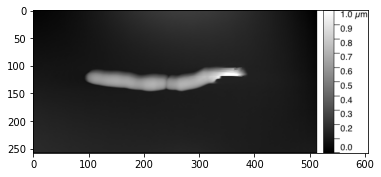

In [203]:
plt.imshow(im)

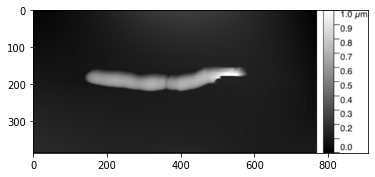

In [204]:
plt.imshow(scaled_im)